# Import libs

In [1]:
import sys
import os
import itertools
sys.path.append('..')
from eflow.foundation import DataPipeline,DataFrameTypes
from eflow.model_analysis import ClassificationAnalysis
from eflow.utils.modeling_utils import optimize_model_grid
from eflow.utils.eflow_utils import get_type_holder_from_pipeline, remove_unconnected_pipeline_segments
from eflow.utils.sys_utils import load_pickle_object
from eflow.utils.pandas_utils import data_types_table
from eflow.auto_modeler import AutoCluster
from eflow.data_pipeline_segments import DataEncoder

import pandas as pd
import numpy as np
from dtreeviz.trees import *
from functools import partial
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import copy
import pickle
import time
import math
import multiprocessing as mp
from functools import partial
from scipy import stats
from IPython.display import clear_output

In [2]:
%matplotlib notebook
%matplotlib inline

## Declare Project Variables

### Interaction required

In [3]:
dataset_path = "Datasets/titanic_train.csv"

# -----
dataset_name = "Titanic Data"
pipeline_name = "Titanic Pipeline"

# -----


# -----
notebook_mode = True

## Clean out segment space

In [4]:
remove_unconnected_pipeline_segments()

# Import dataset

In [5]:
df = pd.read_csv(dataset_path)
shape_df = pd.DataFrame.from_dict({'Rows': [df.shape[0]],
                                   'Columns': [df.shape[1]]})
display(shape_df)
display(df.head(30))

,Rows,Columns
0,891,12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
data_types_table(df)

,Data Types
Features,
Age,float64
Fare,float64
PassengerId,int64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Name,object
Sex,object


# Loading and init df_features

In [7]:
# Option: 1
# df_features = get_type_holder_from_pipeline(pipeline_name)

In [8]:
# Option: 2
df_features = DataFrameTypes()
df_features.init_on_json_file(os.getcwd() + f"/eflow Data/{dataset_name}/df_features.json")

In [9]:
df_features.display_features(display_dataframes=True,
                             notebook_mode=notebook_mode)

,Data Types
Features,
Embarked,string
Cabin,string
Pclass,string
Sex,string
Survived,bool
Parch,integer
SibSp,integer
Age,float
Fare,float


# Any extra processing before eflow DataPipeline

# Setup pipeline structure

### Interaction Required

In [10]:
main_pipe = DataPipeline(pipeline_name,
                         df,
                         df_features)

The file 'root_pipeline.json' exist!
Now configuring object with proper pipeline segments...
Removing the feature: "PassengerId"
Removing the feature: "Name"
Removing the feature: "Ticket"


In [11]:
main_pipe.perform_pipeline(df,
                           df_features)

In [12]:
df.drop(columns=[df_features.target_feature()],
        inplace=True)
df_features.remove_feature(df_features.target_feature())

# Declare Variables

In [13]:
qualitative_features=list(df_features.get_dummy_encoded_features().keys())

In [14]:
require_binning = df_features.continuous_numerical_features()
require_binning

{'Age', 'Fare', 'Parch', 'SibSp'}

In [15]:
require_binning -= {'Parch', 'SibSp'}
require_binning

{'Age', 'Fare'}

In [16]:
df

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Sex_female,Sex_male
0,22.000000,1,0,7.2500,False,False,True,False,False,True,False,True
1,38.000000,1,0,71.2833,True,False,False,True,False,False,True,False
2,26.000000,0,0,7.9250,False,False,True,False,False,True,True,False
3,35.000000,1,0,53.1000,True,False,False,False,False,True,True,False
4,35.000000,0,0,8.0500,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.000000,0,0,13.0000,False,True,False,False,False,True,False,True
887,19.000000,0,0,30.0000,True,False,False,False,False,True,True,False
888,28.312774,1,2,23.4500,False,False,True,False,False,True,True,False
889,26.000000,0,0,30.0000,True,False,False,True,False,False,False,True


In [17]:
data_encoder = DataEncoder(create_file=False)

In [18]:
data_encoder.revert_dummies(df,
                            df_features,
                            qualitative_features=qualitative_features)

In [19]:
df

,Age,SibSp,Parch,Fare,Pclass,Embarked,Sex
0,22.000000,1,0,7.2500,3,Southampton,male
1,38.000000,1,0,71.2833,1,Cherbourg,female
2,26.000000,0,0,7.9250,3,Southampton,female
3,35.000000,1,0,53.1000,1,Southampton,female
4,35.000000,0,0,8.0500,3,Southampton,male
...,...,...,...,...,...,...,...
886,27.000000,0,0,13.0000,2,Southampton,male
887,19.000000,0,0,30.0000,1,Southampton,female
888,28.312774,1,2,23.4500,3,Southampton,female
889,26.000000,0,0,30.0000,1,Cherbourg,male


In [20]:
data_encoder.apply_binning(df,
                           df_features,
                           require_binning)

In [21]:
df

,Age,SibSp,Parch,Fare,Pclass,Embarked,Sex
0,16.336+ ⟷ 32.252,1,0,-0.512+ ⟷ 102.466,3,Southampton,male
1,32.252+ ⟷ 48.168,1,0,-0.512+ ⟷ 102.466,1,Cherbourg,female
2,16.336+ ⟷ 32.252,0,0,-0.512+ ⟷ 102.466,3,Southampton,female
3,32.252+ ⟷ 48.168,1,0,-0.512+ ⟷ 102.466,1,Southampton,female
4,32.252+ ⟷ 48.168,0,0,-0.512+ ⟷ 102.466,3,Southampton,male
...,...,...,...,...,...,...,...
886,16.336+ ⟷ 32.252,0,0,-0.512+ ⟷ 102.466,2,Southampton,male
887,16.336+ ⟷ 32.252,0,0,-0.512+ ⟷ 102.466,1,Southampton,female
888,16.336+ ⟷ 32.252,1,2,-0.512+ ⟷ 102.466,3,Southampton,female
889,16.336+ ⟷ 32.252,0,0,-0.512+ ⟷ 102.466,1,Cherbourg,male


In [22]:
value_matrix = []

for feature_name in df.columns:
    value_matrix.append(df[feature_name].dropna().unique().tolist())

feature_columns = copy.deepcopy(df.columns)
del df

In [23]:
df = pd.DataFrame(list(itertools.product(*value_matrix)), columns=feature_columns)

In [24]:
df

,Age,SibSp,Parch,Fare,Pclass,Embarked,Sex
0,16.336+ ⟷ 32.252,1,0,-0.512+ ⟷ 102.466,3,Southampton,male
1,16.336+ ⟷ 32.252,1,0,-0.512+ ⟷ 102.466,3,Southampton,female
2,16.336+ ⟷ 32.252,1,0,-0.512+ ⟷ 102.466,3,Cherbourg,male
3,16.336+ ⟷ 32.252,1,0,-0.512+ ⟷ 102.466,3,Cherbourg,female
4,16.336+ ⟷ 32.252,1,0,-0.512+ ⟷ 102.466,3,Queenstown,male
...,...,...,...,...,...,...,...
13225,64.084+ ⟷ 80.0,8,6,102.466+ ⟷ 204.932,2,Southampton,female
13226,64.084+ ⟷ 80.0,8,6,102.466+ ⟷ 204.932,2,Cherbourg,male
13227,64.084+ ⟷ 80.0,8,6,102.466+ ⟷ 204.932,2,Cherbourg,female
13228,64.084+ ⟷ 80.0,8,6,102.466+ ⟷ 204.932,2,Queenstown,male


In [25]:
data_encoder.make_dummies(df,
                            df_features,
                            qualitative_features=qualitative_features)

In [26]:
df

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Sex_female,Sex_male
0,16.336+ ⟷ 32.252,1,0,-0.512+ ⟷ 102.466,False,False,True,False,False,True,False,True
1,16.336+ ⟷ 32.252,1,0,-0.512+ ⟷ 102.466,False,False,True,False,False,True,True,False
2,16.336+ ⟷ 32.252,1,0,-0.512+ ⟷ 102.466,False,False,True,True,False,False,False,True
3,16.336+ ⟷ 32.252,1,0,-0.512+ ⟷ 102.466,False,False,True,True,False,False,True,False
4,16.336+ ⟷ 32.252,1,0,-0.512+ ⟷ 102.466,False,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
13225,64.084+ ⟷ 80.0,8,6,102.466+ ⟷ 204.932,False,True,False,False,False,True,True,False
13226,64.084+ ⟷ 80.0,8,6,102.466+ ⟷ 204.932,False,True,False,True,False,False,False,True
13227,64.084+ ⟷ 80.0,8,6,102.466+ ⟷ 204.932,False,True,False,True,False,False,True,False
13228,64.084+ ⟷ 80.0,8,6,102.466+ ⟷ 204.932,False,True,False,False,True,False,False,True


In [27]:
for feature_name, bins_labels in df_features.get_all_feature_binning().items():
    bins = bins_labels["bins"]
    labels = bins_labels["labels"]
    label_bin_avg = dict()
    for i,l in enumerate(labels):
        label_bin_avg[l] = sum(bins[i:i+2])/2
         
    df.replace(label_bin_avg,inplace=True)

In [28]:
df

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Sex_female,Sex_male
0,24.294,1,0,50.977,False,False,True,False,False,True,False,True
1,24.294,1,0,50.977,False,False,True,False,False,True,True,False
2,24.294,1,0,50.977,False,False,True,True,False,False,False,True
3,24.294,1,0,50.977,False,False,True,True,False,False,True,False
4,24.294,1,0,50.977,False,False,True,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
13225,72.042,8,6,153.699,False,True,False,False,False,True,True,False
13226,72.042,8,6,153.699,False,True,False,True,False,False,False,True
13227,72.042,8,6,153.699,False,True,False,True,False,False,True,False
13228,72.042,8,6,153.699,False,True,False,False,True,False,False,True


# Load Model

In [29]:
model = load_pickle_object("/Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlow/testing/eflow Data/Titanic Data/Classification Analysis/Target Feature: Survived/RandomForestClassifier/RandomForestClassifier.pkl")
model_predictions = model.predict(df)
predicted_classes = set(sorted(model_predictions.tolist()))
cluster_results = [None for i in range(0,len(model_predictions))]

target=0

Inspecting scaled results!


,Mean,Standard Dev
Age,2.149902e-16,1.0
SibSp,-1.433268e-17,1.0
Parch,-4.568543e-17,1.0
Fare,-6.270549e-17,1.0
Pclass_1,5.016439e-17,1.0
Pclass_2,6.270549e-17,1.0
Pclass_3,-7.882975e-17,1.0
Embarked_Cherbourg,2.888931e-17,1.0
Embarked_Queenstown,-3.672750e-17,1.0
Embarked_Southampton,-1.030162e-16,1.0


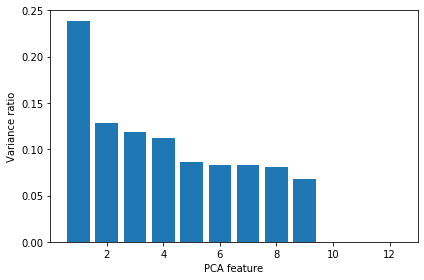

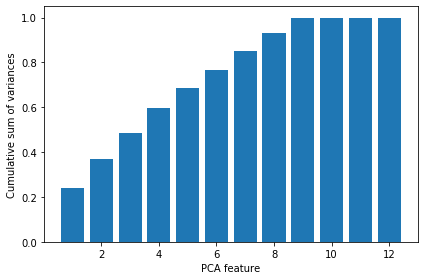


Inspecting applied scaler and pca results!


,Mean,Standard Dev
PCA_Feature_1,2.149902e-17,1.691476e+00
PCA_Feature_2,1.164530e-17,1.243222e+00
PCA_Feature_3,2.508219e-17,1.192476e+00
PCA_Feature_4,-6.852814e-17,1.162669e+00
PCA_Feature_5,3.583171e-17,1.019107e+00
PCA_Feature_6,3.941488e-17,1.000639e+00
PCA_Feature_7,-3.583171e-18,9.974702e-01
PCA_Feature_8,4.299805e-17,9.853978e-01
PCA_Feature_9,-1.433268e-17,9.020515e-01
PCA_Feature_10,-1.015853e-17,4.553212e-16


After applying pca with a cutoff percentage 0.8% for the cumulative index. Using features 1 to 7
Old shape (7932, 12)
New shape (7932, 7)

Inspecting data after final scaler applied!


,Mean,Standard Dev
PCA_Feature_1,1.433268e-17,1.0
PCA_Feature_2,8.062134e-18,1.0
PCA_Feature_3,1.433268e-17,1.0
PCA_Feature_4,-2.687378e-17,1.0
PCA_Feature_5,-7.166341e-18,1.0
PCA_Feature_6,2.149902e-17,1.0
PCA_Feature_7,-1.074951e-17,1.0


K-Means Elbow Seq Count 1:   0%|          | 0/11 [00:00<?, ?it/s, model_count=1]

Found past models in directory structure! Attempting to re-initalize models...
K-Means_Clusters=5 was found at /Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlow/testing/eflow Data/Titanic Data/Exansion Auto Clustering/Clustering/Target=0/Models/K-Means/Clusters=5/K-Means_Clusters=5.pkl

K-Means_Clusters=4 was found at /Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlow/testing/eflow Data/Titanic Data/Exansion Auto Clustering/Clustering/Target=0/Models/K-Means/Clusters=4/K-Means_Clusters=4.pkl

K-Means_Clusters=6 was found at /Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlow/testing/eflow Data/Titanic Data/Exansion Auto Clustering/Clustering/Target=0/Models/K-Means/Clusters=6/K-Means_Clusters=6.pkl



K-Means Elbow Seq Count 10: 100%|██████████| 11/11 [00:05<00:00,  2.11it/s, model_count=11]
../eflow/auto_modeler/cluster_master.py:1317: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  inertias_matrix = np.matrix([inertias[i]])
../eflow/auto_modeler/cluster_master.py:1318: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  elbow_inertias_matrix = np.matrix(inertias[i][elbow_cluster - 2:elbow_cluster + 1])


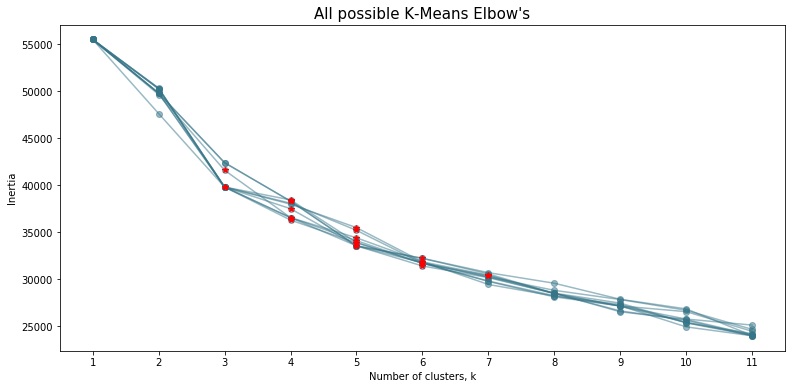

[55524.00000000001, 49805.39694246038, 42406.11920446067, 38300.369512971796, 33536.63908900393, 32204.75717679786, 30545.767735142323, 28460.781202054735, 27130.811781699365, 26524.498202238752, 24436.03606587423]


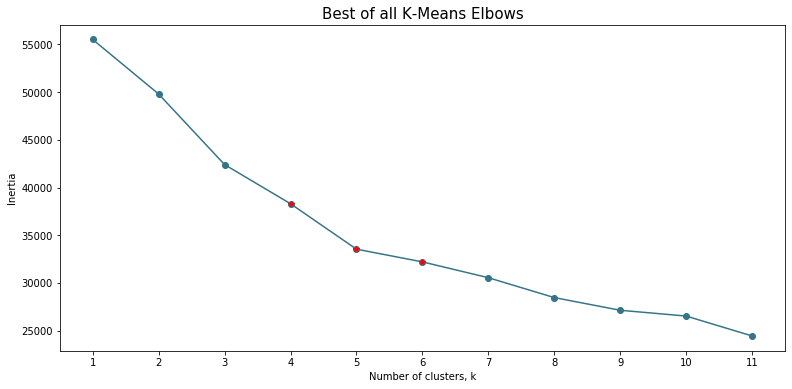

,Proximity Elbow,Counts
1,5,10
0,4,8
2,6,6
3,3,4
4,7,2


,Main Elbows,Counts
0,5,4
1,4,4
2,6,2


target=1

Inspecting scaled results!


,Mean,Standard Dev
Age,-1.716676e-16,1.0
SibSp,1.448445e-16,1.0
Parch,-1.019276e-16,1.0
Fare,-1.663029e-16,1.0
Pclass_1,1.341153e-17,1.0
Pclass_2,8.046917e-17,1.0
Pclass_3,-3.218767e-17,1.0
Embarked_Cherbourg,-7.275754e-17,1.0
Embarked_Queenstown,5.766957e-17,1.0
Embarked_Southampton,1.341153e-17,1.0


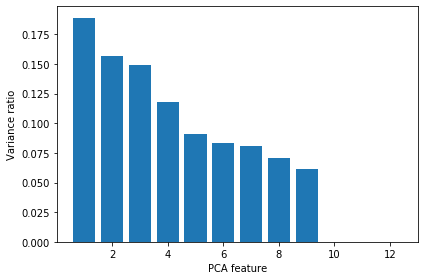

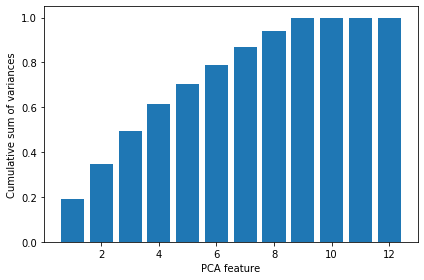


Inspecting applied scaler and pca results!


,Mean,Standard Dev
PCA_Feature_1,0.000000e+00,1.506544e+00
PCA_Feature_2,2.682306e-17,1.371060e+00
PCA_Feature_3,-3.889343e-17,1.339065e+00
PCA_Feature_4,5.364611e-18,1.189138e+00
PCA_Feature_5,3.755228e-17,1.045415e+00
PCA_Feature_6,5.901072e-17,9.994482e-01
PCA_Feature_7,-3.218767e-17,9.846626e-01
PCA_Feature_8,3.218767e-17,9.193182e-01
PCA_Feature_9,-3.218767e-17,8.584182e-01
PCA_Feature_10,3.070597e-17,8.118174e-16


After applying pca with a cutoff percentage 0.8% for the cumulative index. Using features 1 to 7
Old shape (5298, 12)
New shape (5298, 7)

Inspecting data after final scaler applied!


,Mean,Standard Dev
PCA_Feature_1,2.145844e-17,1.0
PCA_Feature_2,2.682306e-17,1.0
PCA_Feature_3,-2.615248e-17,1.0
PCA_Feature_4,5.364611e-18,1.0
PCA_Feature_5,3.218767e-17,1.0
PCA_Feature_6,3.621112e-17,1.0
PCA_Feature_7,-2.145844e-17,1.0


K-Means Elbow Seq Count 1:   0%|          | 0/11 [00:00<?, ?it/s, model_count=1]

Found past models in directory structure! Attempting to re-initalize models...
K-Means_Clusters=5 was found at /Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlow/testing/eflow Data/Titanic Data/Exansion Auto Clustering/Clustering/Target=1/Models/K-Means/Clusters=5/K-Means_Clusters=5.pkl

K-Means_Clusters=7 was found at /Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlow/testing/eflow Data/Titanic Data/Exansion Auto Clustering/Clustering/Target=1/Models/K-Means/Clusters=7/K-Means_Clusters=7.pkl

K-Means_Clusters=4 was found at /Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlow/testing/eflow Data/Titanic Data/Exansion Auto Clustering/Clustering/Target=1/Models/K-Means/Clusters=4/K-Means_Clusters=4.pkl

K-Means_Clusters=6 was found at /Users/ericcacciavillani/Desktop/Coding/Python_Files/Artificial_Intelligence/Data Mining/eFlow/testing/eflow Data/Titanic Data/

K-Means Elbow Seq Count 10: 100%|██████████| 11/11 [00:03<00:00,  3.12it/s, model_count=11]
../eflow/auto_modeler/cluster_master.py:1317: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  inertias_matrix = np.matrix([inertias[i]])
../eflow/auto_modeler/cluster_master.py:1318: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  elbow_inertias_matrix = np.matrix(inertias[i][elbow_cluster - 2:elbow_cluster + 1])


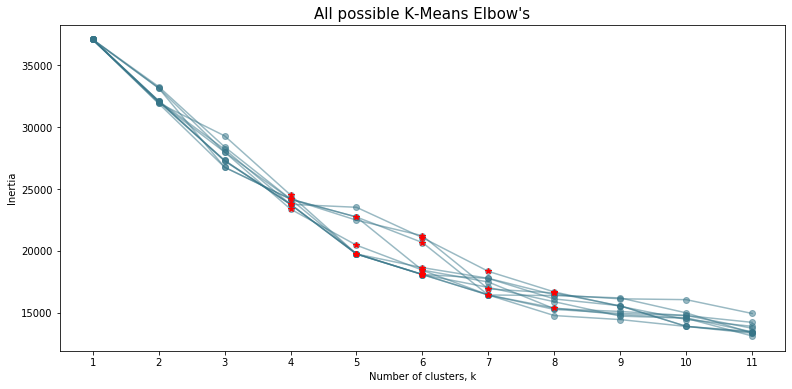

[37085.999999999956, 32039.616779961074, 27984.115833626918, 24178.261520799897, 22732.094390293558, 18425.438607209308, 16424.85402400534, 15260.34854417227, 14934.60918192878, 14764.092486418274, 14212.861444959295]


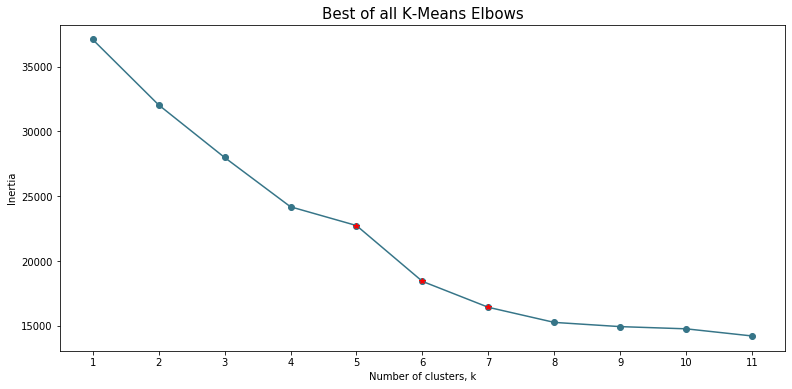

,Proximity Elbow,Counts
0,6,10
3,5,7
4,4,6
1,7,4
2,8,3


,Main Elbows,Counts
2,5,6
0,7,3
1,6,1


In [30]:
cluster_label_buffer = 0
cluster_cut_off_points = []
for target in predicted_classes:
    print(f"target={target}")
    bool_array = model_predictions == target
    auto_cluster = AutoCluster(df[bool_array],
                               project_name=f"Exansion Auto Clustering/Clustering/Target={target}",
                               project_sub_dir=dataset_name,
                               overwrite_full_path=None,
                               notebook_mode=True,
                               pca_perc=.8)

    best_clusters = auto_cluster.create_elbow_models(model_names=["K-Means"],
                                                     sequences=10,
                                                     max_k_value=11,
                                                     display_visuals=True)
    
    cluster_model = load_pickle_object(auto_cluster.folder_path + f"Models/K-Means/Clusters={best_clusters[1]}/K-Means_Clusters={best_clusters[1]}.pkl")
    tmp_results = cluster_model.predict(auto_cluster.apply_clustering_data_pipeline(df[bool_array]))
    
    
    cluster_count = 0
    for i,replace_val in enumerate(bool_array):
        if replace_val:
            cluster_results[i] = tmp_results[cluster_count] + cluster_label_buffer
            cluster_count += 1
            
    cluster_label_buffer += best_clusters[1]
    if len(cluster_cut_off_points):
        cluster_cut_off_points.append(cluster_cut_off_points[-1] + best_clusters[1])
    else:
        cluster_cut_off_points.append(best_clusters[1])
        

In [31]:
df["Target"] = cluster_results

In [32]:
df

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Sex_female,Sex_male,Target
0,24.294,1,0,50.977,False,False,True,False,False,True,False,True,0
1,24.294,1,0,50.977,False,False,True,False,False,True,True,False,0
2,24.294,1,0,50.977,False,False,True,True,False,False,False,True,2
3,24.294,1,0,50.977,False,False,True,True,False,False,True,False,6
4,24.294,1,0,50.977,False,False,True,False,True,False,False,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13225,72.042,8,6,153.699,False,True,False,False,False,True,True,False,8
13226,72.042,8,6,153.699,False,True,False,True,False,False,False,True,2
13227,72.042,8,6,153.699,False,True,False,True,False,False,True,False,8
13228,72.042,8,6,153.699,False,True,False,False,True,False,False,True,3


# Seperate out data into train and test sets

In [33]:
feature_order = list(df.columns)
feature_order.remove("Target")

In [34]:
feature_order

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_Cherbourg',
 'Embarked_Queenstown',
 'Embarked_Southampton',
 'Sex_female',
 'Sex_male']

In [35]:
X = df.drop(columns="Target").values
y = df["Target"].values
del df

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=517,
    stratify=y,
)

In [37]:
del X
del y

In [38]:
# Find best parameters for model
param_grid = {
    "criterion": ["entropy", "gini"],
    "max_depth": [4,5,6,7,8,9,10,11,12,13,14,15,16],
    "min_samples_split": [2,5,10,15,30,40,50,60,70,80]
}

model, best_params = optimize_model_grid(
    model=DecisionTreeClassifier(),
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid,
    scoring="f1_micro",
    n_jobs=-1
)

Tuned Parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 2}
Best score on trained data was 0.996221


In [39]:
model_name = repr(model).split("(")[0]
model_name 

'DecisionTreeClassifier'

In [40]:
model_analysis = ClassificationAnalysis(dataset_name=dataset_name,
                                        project_sub_dir="Exansion Auto Clustering/Modeling for DT",
                                        model=model,
                                        model_name=model_name,
                                        feature_order=feature_order,
                                        target_feature=df_features.target_feature(),
                                        pred_funcs_dict={"Probabilities function":model.predict_proba,
                                                         "Predict function":model.predict},
                                        sample_data=X_train[0],
                                        notebook_mode=notebook_mode,
                                        df_features=df_features)



------------------------------Train Data------------------------------
Now running classification on Probabilities function on no thresholds.

Shape of the data is (9261, 12)


,Metric Scores
Precision(micro),1.0000
Precision(macro),1.0000
Precision(weighted),1.0000
MCC,1.0000
Recall(micro),1.0000
Recall(macro),1.0000
Recall(weighted),1.0000
F1-Score(micro),1.0000
F1-Score(macro),1.0000
F1-Score(weighted),1.0000


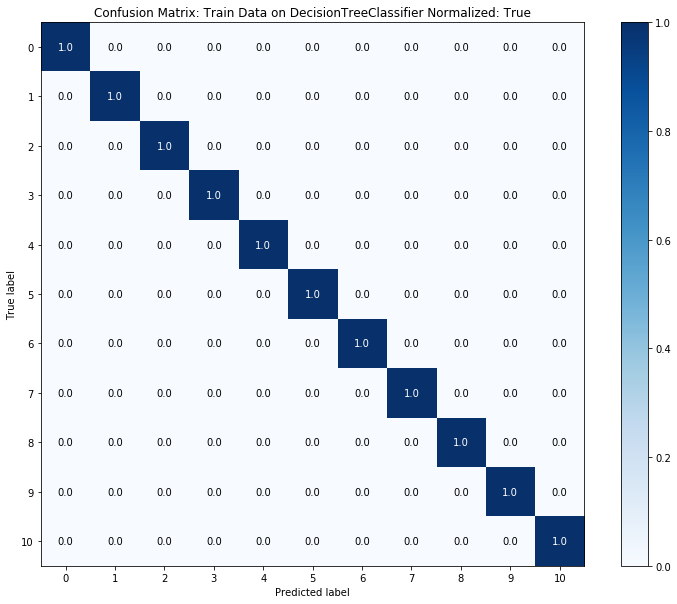

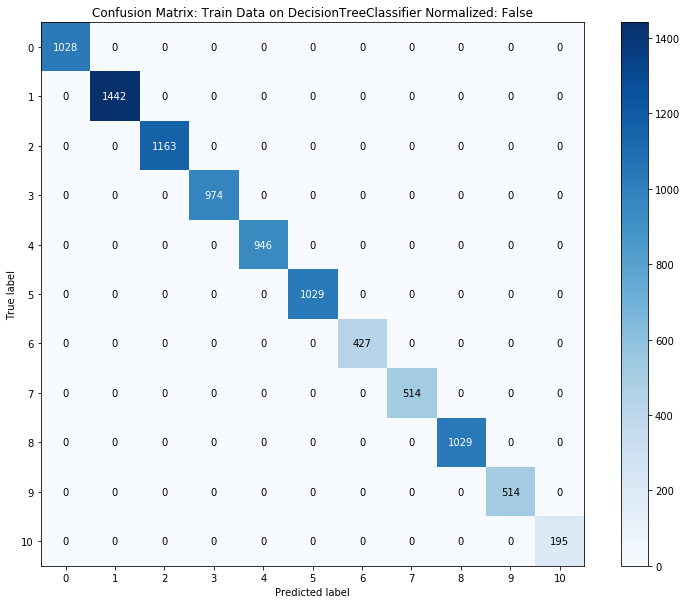

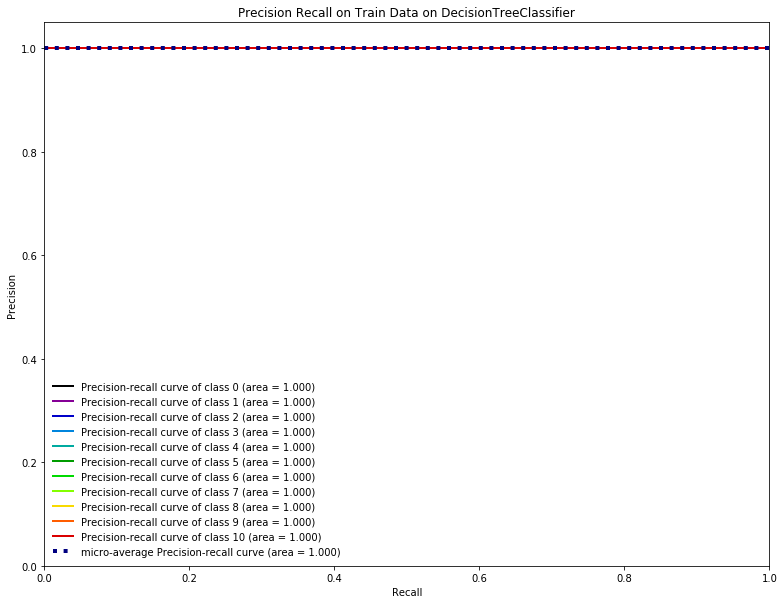

/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/scikitplot/metrics.py:443: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])


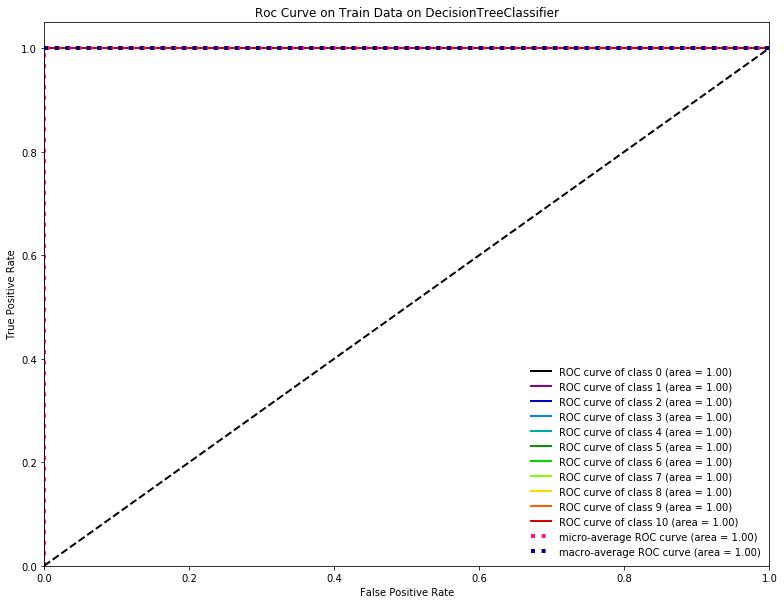

----------------------------------------------------------------------





Now running classification on Predict function

Shape of the data is (9261, 12)


,Metric Scores
Precision(micro),1.0000
Precision(macro),1.0000
Precision(weighted),1.0000
MCC,1.0000
Recall(micro),1.0000
Recall(macro),1.0000
Recall(weighted),1.0000
F1-Score(micro),1.0000
F1-Score(macro),1.0000
F1-Score(weighted),1.0000


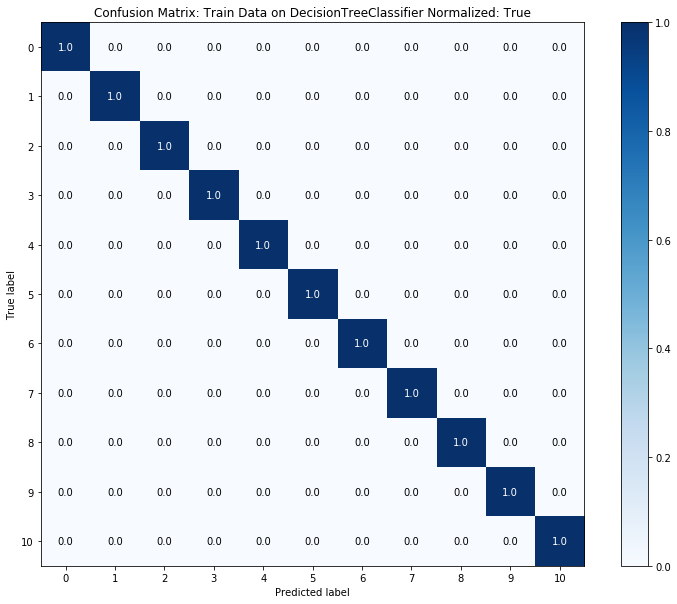

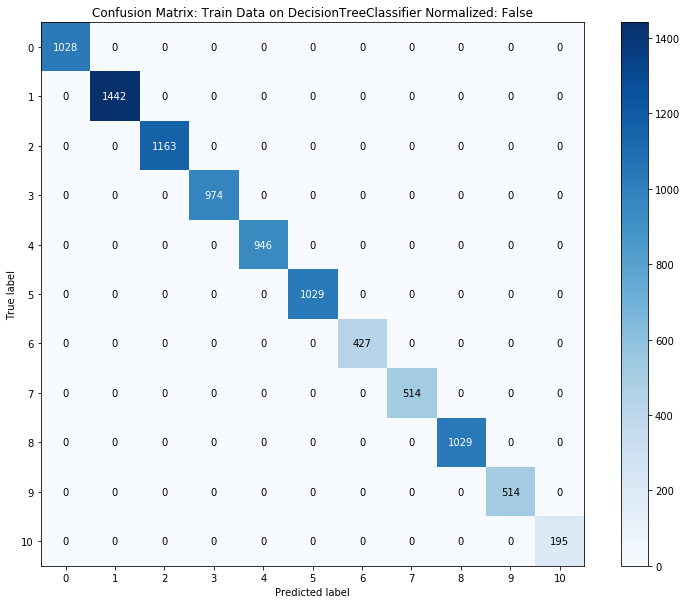

----------------------------------------------------------------------



In [41]:
model_analysis.perform_analysis(X=X_train,
                                y=y_train,
                                dataset_name="Train Data",
                                classification_error_analysis=False,
                                classification_correct_analysis=False)



------------------------------Test Data------------------------------
Now running classification on Probabilities function on no thresholds.

Shape of the data is (3969, 12)


,Metric Scores
Precision(micro),0.9952
Precision(macro),0.9914
Precision(weighted),0.9952
MCC,0.9946
Recall(micro),0.9952
Recall(macro),0.9931
Recall(weighted),0.9952
F1-Score(micro),0.9952
F1-Score(macro),0.9922
F1-Score(weighted),0.9952


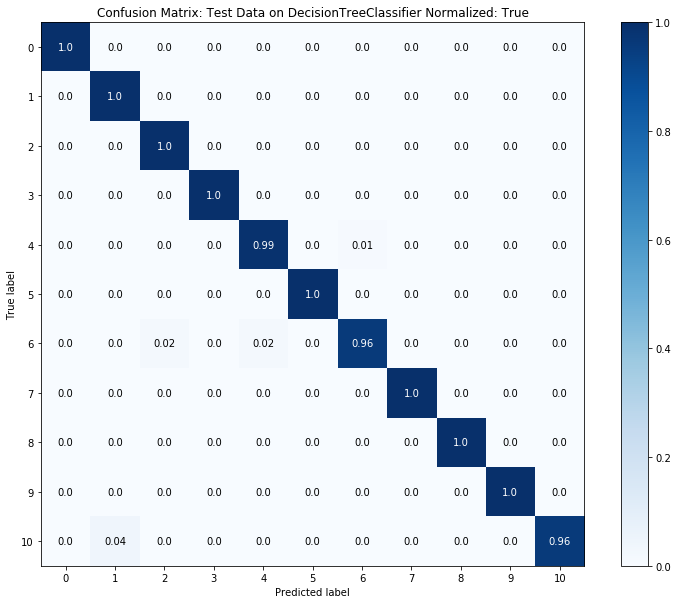

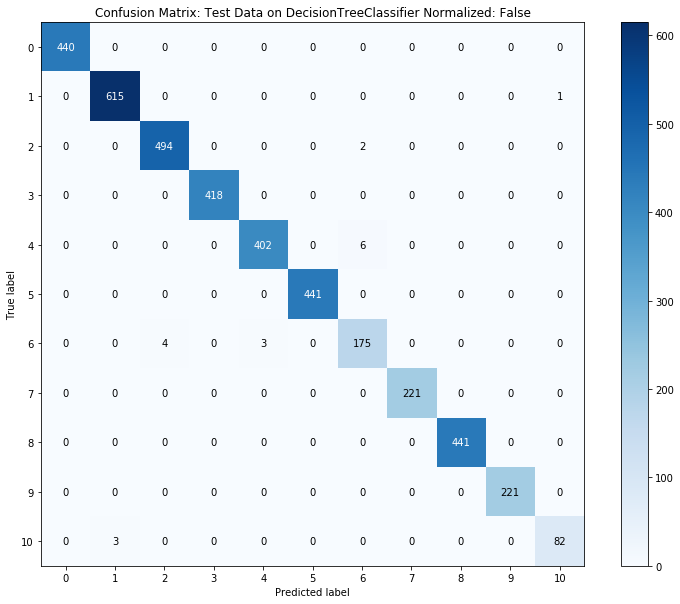

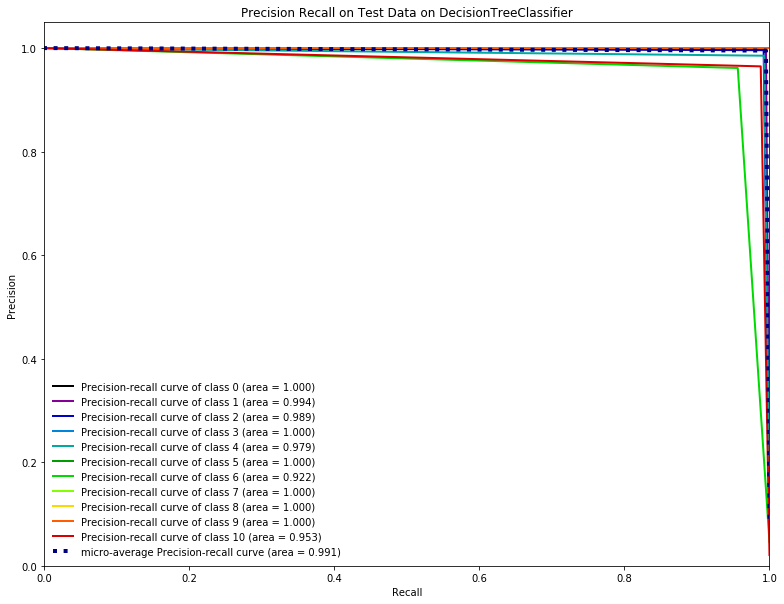

/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/scikitplot/metrics.py:443: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])


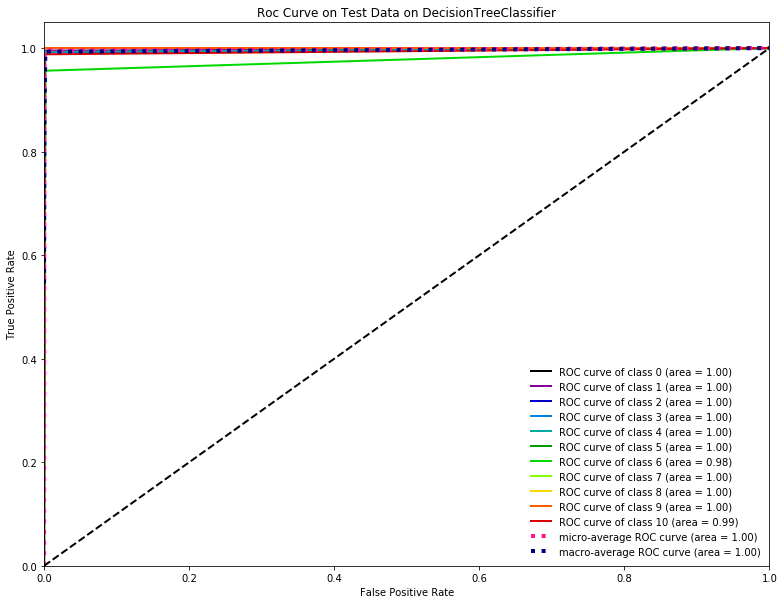

---------------------------------------------------------------------





Now running classification on Predict function

Shape of the data is (3969, 12)


,Metric Scores
Precision(micro),0.9952
Precision(macro),0.9914
Precision(weighted),0.9952
MCC,0.9946
Recall(micro),0.9952
Recall(macro),0.9931
Recall(weighted),0.9952
F1-Score(micro),0.9952
F1-Score(macro),0.9922
F1-Score(weighted),0.9952


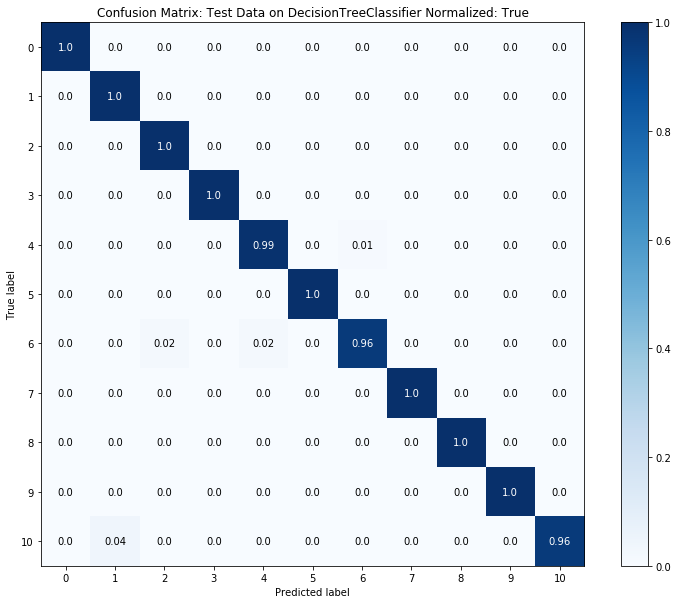

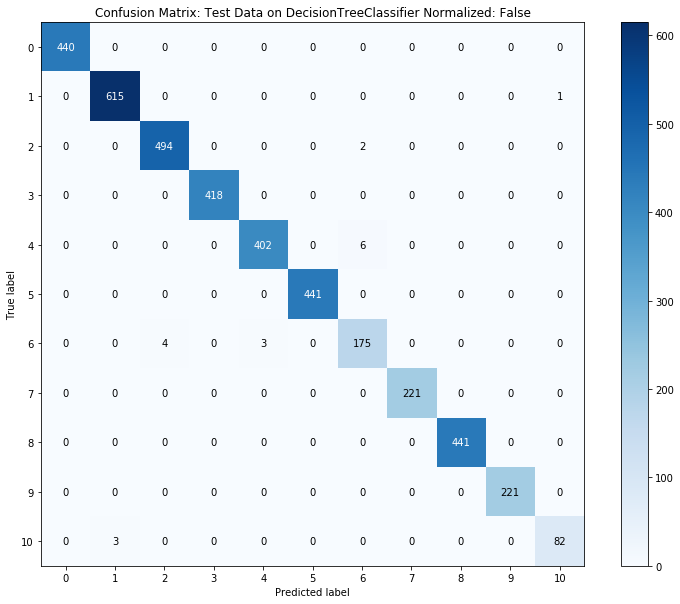

---------------------------------------------------------------------



In [42]:
model_analysis.perform_analysis(X=X_test,
                                y=y_test,
                                dataset_name="Test Data",
                                classification_error_analysis=False,
                                classification_correct_analysis=False)

In [43]:
viz = dtreeviz(model, 
               X_test, 
               y_test,
               target_name='Target',
               feature_names=feature_order, 
               class_names=model.classes_.tolist())

IndexError: list index out of range

In [ ]:
viz.view()

In [44]:
cluster_cut_off_points

[5, 11]

In [45]:
def expansion_prediction(model,
                         predicted_classes,
                         cluster_cut_off_points,
                         data):
    try:
        y_preds = model.predict(data)
    except AttributeError:
        pass

    for i,_ in enumerate(y_preds):
        for label_index,label in enumerate(cluster_cut_off_points):
            if y_preds[i] < label:
                y_preds[i] = list(predicted_classes)[label_index]
                break
    return y_preds

In [46]:
dt_prediction = partial(expansion_prediction,
                        model,
                        predicted_classes,
                        cluster_cut_off_points)

In [47]:
del X_train
del X_test
del y_train
del y_test

# Re-import dataset

In [48]:
df = pd.read_csv(dataset_path)
shape_df = pd.DataFrame.from_dict({'Rows': [df.shape[0]],
                                   'Columns': [df.shape[1]]})
display(shape_df)
display(df.head(30))

,Rows,Columns
0,891,12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [49]:
data_types_table(df)

,Data Types
Features,
Age,float64
Fare,float64
PassengerId,int64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Name,object
Sex,object


# Loading and init df_features

In [50]:
# Option: 1
# df_features = get_type_holder_from_pipeline(pipeline_name)

In [51]:
# Option: 2
df_features = DataFrameTypes()
df_features.init_on_json_file(os.getcwd() + f"/eflow Data/{dataset_name}/df_features.json")

In [52]:
df_features.display_features(display_dataframes=True,
                             notebook_mode=notebook_mode)

,Data Types
Features,
Embarked,string
Cabin,string
Pclass,string
Sex,string
Survived,bool
Parch,integer
SibSp,integer
Age,float
Fare,float


# Any extra processing before eflow DataPipeline

# Setup pipeline structure

### Interaction Required

In [53]:
main_pipe = DataPipeline(pipeline_name,
                         df,
                         df_features)

The file 'root_pipeline.json' exist!
Now configuring object with proper pipeline segments...
Removing the feature: "PassengerId"
Removing the feature: "Name"
Removing the feature: "Ticket"


In [54]:
main_pipe.perform_pipeline(df,
                           df_features)

In [55]:
df

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Sex_female,Sex_male
0,0,22.000000,1,0,7.2500,False,False,True,False,False,True,False,True
1,1,38.000000,1,0,71.2833,True,False,False,True,False,False,True,False
2,1,26.000000,0,0,7.9250,False,False,True,False,False,True,True,False
3,1,35.000000,1,0,53.1000,True,False,False,False,False,True,True,False
4,0,35.000000,0,0,8.0500,False,False,True,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.000000,0,0,13.0000,False,True,False,False,False,True,False,True
887,1,19.000000,0,0,30.0000,True,False,False,False,False,True,True,False
888,0,28.312774,1,2,23.4500,False,False,True,False,False,True,True,False
889,1,26.000000,0,0,30.0000,True,False,False,True,False,False,False,True


In [56]:
feature_order = list(df.columns)

In [57]:
feature_order

['Survived',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_Cherbourg',
 'Embarked_Queenstown',
 'Embarked_Southampton',
 'Sex_female',
 'Sex_male']

In [58]:
X = df.drop(columns=df_features.target_feature()).values
y = df[df_features.target_feature()].values
del df

In [60]:
model_analysis = ClassificationAnalysis(dataset_name=dataset_name,
                                        project_sub_dir="Exansion Auto Clustering/Modeling for DT/Actual results",
                                        model=model,
                                        model_name=model_name,
                                        feature_order=feature_order,
                                        target_feature=df_features.target_feature(),
                                        pred_funcs_dict={"Predict function":dt_prediction},
                                        sample_data=X[0],
                                        notebook_mode=notebook_mode,
                                        df_features=df_features)



------------------------------All Data------------------------------
Now running classification on Predict function

Shape of the data is (891, 12)


,Metric Scores
Precision(micro),0.8272
Precision(macro),0.8499
Precision(weighted),0.8387
MCC,0.6350
Recall(micro),0.8272
Recall(macro),0.7881
Recall(weighted),0.8272
F1-Score(micro),0.8272
F1-Score(macro),0.8028
F1-Score(weighted),0.8189


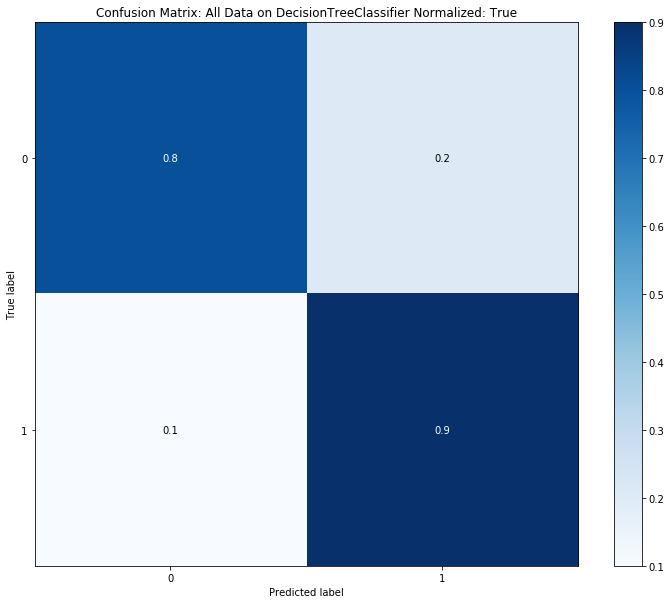

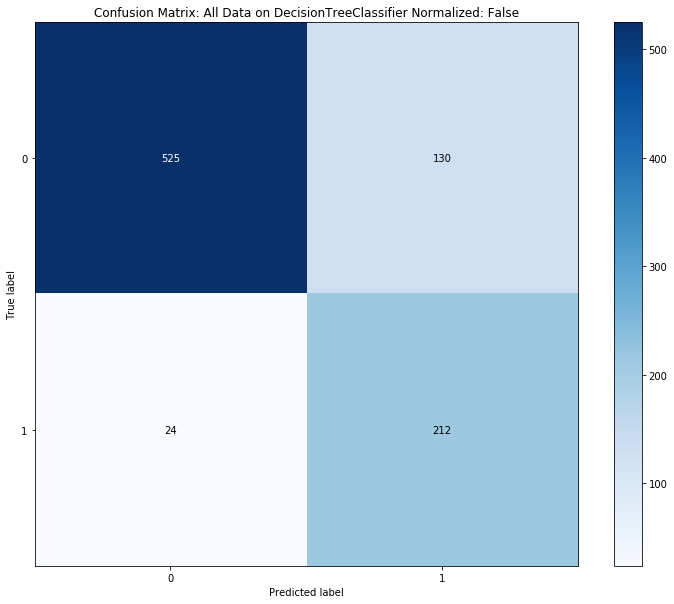

--------------------------------------------------------------------



In [61]:
model_analysis.perform_analysis(X=X,
                                y=y,
                                dataset_name="All Data",
                                classification_error_analysis=False,
                                classification_correct_analysis=False)

In [71]:
feature_order.remove(df_features.target_feature())

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_Cherbourg',
 'Embarked_Queenstown',
 'Embarked_Southampton',
 'Sex_female',
 'Sex_male']

In [1]:
from sklearn.tree import export_text

dtree_node_level_cond = dict()

for tree_info in export_text(model,feature_names=feature_order).split("\n"):
    conditional_value = tree_info.split("|--- ")[1]
    depth_level = len(tree_info.split("|   ")) - 1
    dtree_node_level_cond[depth_level] = conditional_value
    
    if conditional_value[0:7] == "class: ":
        for i_level in range(0,depth_level):
            print(dtree_node_level_cond[i_level])
        
        target_val = int(dtree_node_level_cond[depth_level].split("class: ")[1])
        
        for i,label in enumerate(cluster_cut_off_points):
            if target_val < label:
                print(f"class: {i}")
                break
        print()

NameError: name 'model' is not defined